In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
from statsmodels.regression.mixed_linear_model import MixedLM

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_vr_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_vr_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
fig_dir = "/mnt/BigDisk/YMazeResults/behavior"
os.makedirs(fig_dir,exist_ok=True)
dt = 15.46

In [3]:
print(ko_mice)

('4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', 'Cre7', 'Cre9', 'CA3-1')


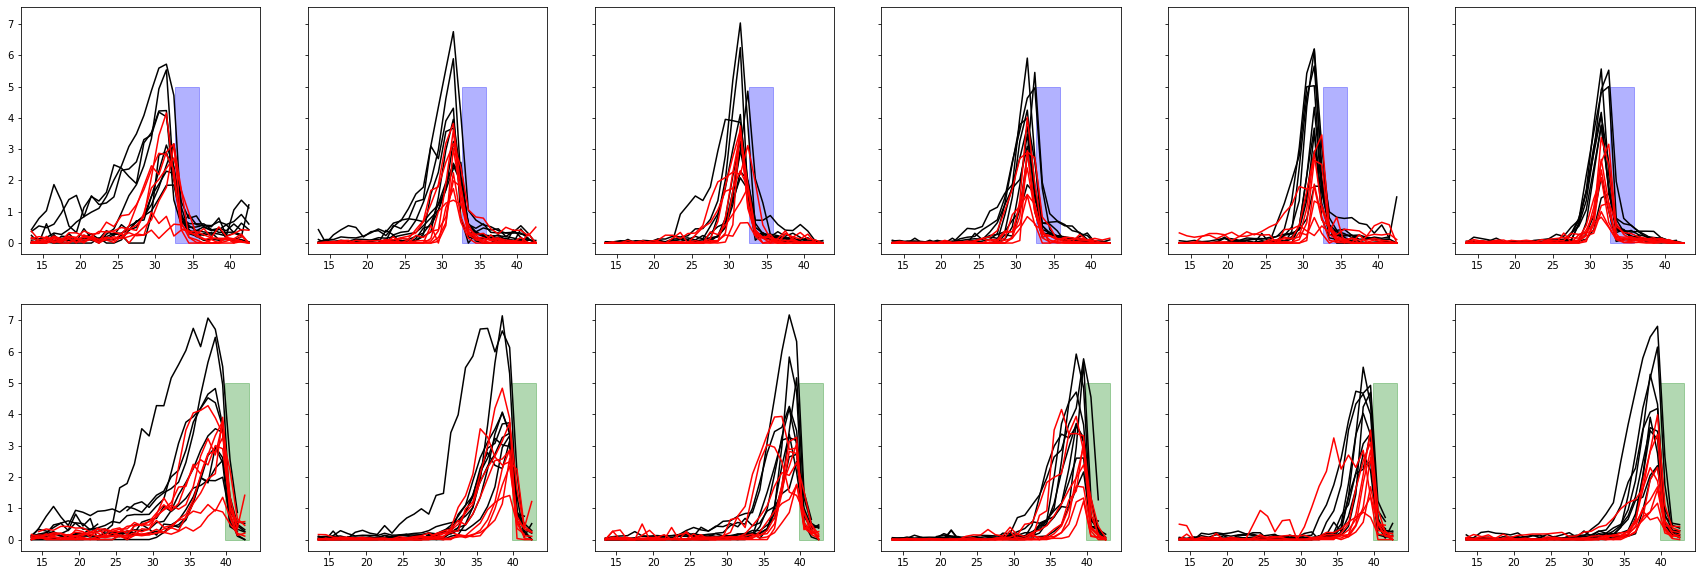

In [4]:
fig, ax = plt.subplots(2,6,figsize=[30,10], sharey=True)

ko_lr = {}
ctrl_lr = {}
for day in range(6):
    
    ctrl_lr[day]={'left':[],'right':[]}
    for i, mouse in enumerate(ctrl_mice):
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        
        ax[0,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:].mean(axis=0),color='black')
        ax[1,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='black')
        
        if i == 0:
            ax[1,day].fill_betweenx([0,5], sess.rzone_late['tfront'], sess.rzone_late['tback'],zorder=0, color='green',alpha=.3)
            ax[0,day].fill_betweenx([0,5],sess.rzone_early['tfront'], sess.rzone_early['tback'],zorder=0, color='blue',alpha=.3)
            
            t_bins = sess.trial_matrices['bin_edges'][1:]
            rzone_early = (t_bins>=sess.rzone_early['tfront']-3)*(t_bins<=sess.rzone_early['tfront'])
            rzone_late = (t_bins>=sess.rzone_late['tfront']-3)*(t_bins<=sess.rzone_late['tfront'])
            
        ctrl_lr[day]['left'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:][:,rzone_early]))
        ctrl_lr[day]['right'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        
    ko_lr[day]={'left':[],'right':[]}
    for i, mouse in enumerate(ko_mice):
        try:
            sess = u.load_vr_day(mouse,day, verbose=False)
            trial_mask = sess.trial_info['LR']==-1
            if day==0 and i == 3:
                trial_mask[35:66]=False

            ax[0,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][trial_mask,:].mean(axis=0),color='red')
            ax[1,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='red')

            ko_lr[day]['left'].append(dt*np.nanmean(sess.trial_matrices['licks'][trial_mask,:][:,rzone_early]))
            ko_lr[day]['right'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        except:
            pass

left day 0: t:-1.347151, p:0.177932
right day 0: t:-1.347151, p:0.177932
left day 1: t:-2.309401, p:0.020921
right day 1: t:-2.309401, p:0.020921
left day 2: t:-1.058475, p:0.289839
right day 2: t:-1.828276, p:0.067508
left day 3: t:-2.598076, p:0.009375
right day 3: t:-2.116951, p:0.034264
left day 4: t:-2.886751, p:0.003892
right day 4: t:-2.886751, p:0.003892
left day 5: t:-2.598076, p:0.009375
right day 5: t:-2.886751, p:0.003892


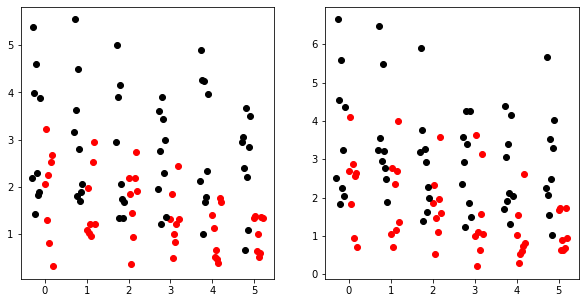

In [5]:
fig, ax = plt.subplots(1,2, figsize=[10,5])

for day in range(6):
    for ax_ind, lr in enumerate(('left', 'right')):
    
        ko = np.array(ko_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day,day+.2, num = ko.shape[0]),ko, color='red')

        ctrl = np.array(ctrl_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day-.3, day-.1, num = ctrl.shape[0]),ctrl, color='black')
    #     print(ko,ctrl)
        t,p = sp.stats.ranksums(ko,ctrl)
        print("%s day %d: t:%f, p:%f" % (lr, day,t,p))

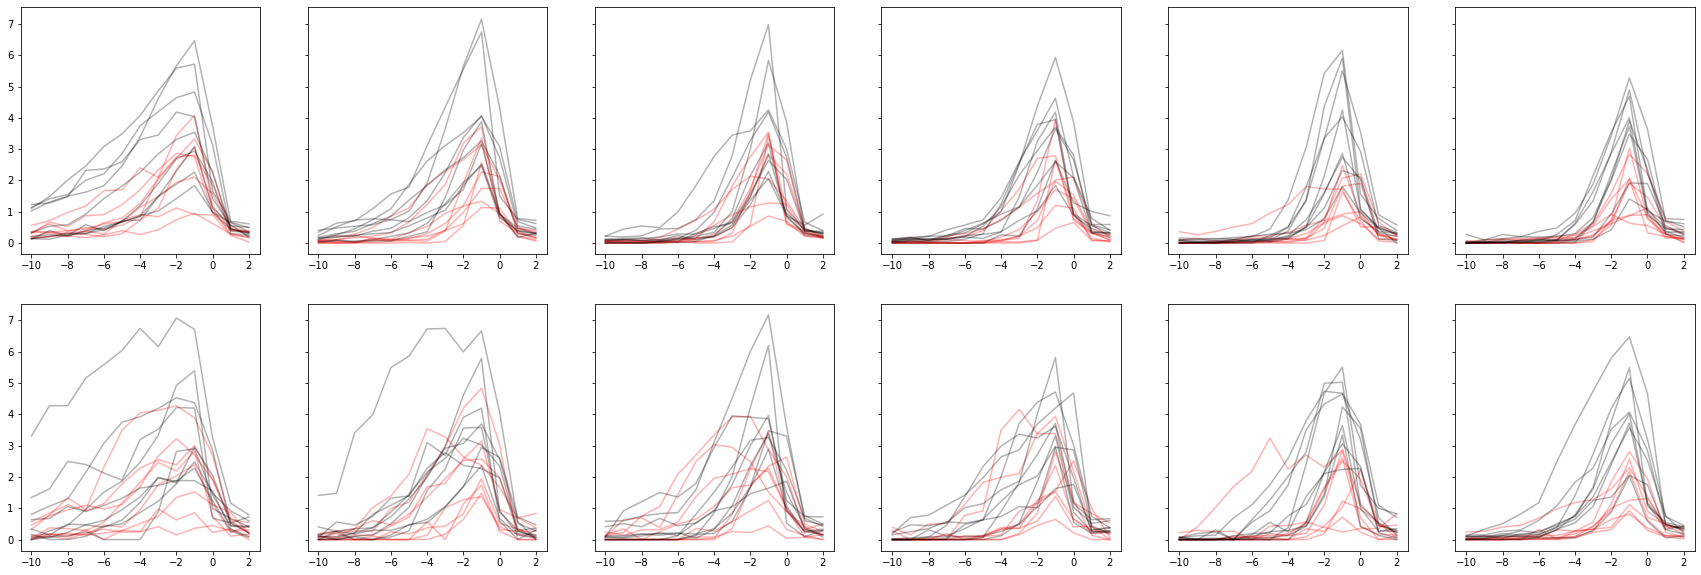

In [6]:

fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)


df = pd.DataFrame({'mouse':[],
                        'ko':[],
                        'day':[],
                        'day_norm': [],
                        'dz': [],
                        'ko_x_day': [],
                        'nov':[],
                        'ko_x_nov': [],
                        'lr': [],
                        'lickrate':[], 
                        'intercept': [],
                        })

key = 'nonconsum_licks'
if key in ('licks', 'nonconsum_licks'):
    alpha = dt
elif key in ('speed'):
    alpha = dt*10
else:
    alpha = 1.
ko_lr, ctrl_lr = {}, {}
for day in range(6):
    ko_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                ax[1,day].plot(x, mu[nov_rzone_front-10:nov_rzone_front+3],color='red', alpha = .3)
                df = df.append({'mouse': mouse, 
                                 'ko': 1, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 1,
                                 'ko_x_nov': 1,
                                 'lr':ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ko_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                ax[0,day].plot(x, mu[fam_rzone_front-10:fam_rzone_front+3],color='red', alpha = .3)
                df = df.append({'mouse': mouse, 
                                 'ko': 1, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
#                 ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                
                    
                
       
                      

    ctrl_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-10,3)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                ax[1,day].plot(x, mu[nov_rzone_front-10:nov_rzone_front+3],color='black', alpha = .3)
                df = df.append({'mouse': mouse, 
                                 'ko': 0, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 1,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ctrl_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                ax[0,day].plot(x, mu[fam_rzone_front-10:fam_rzone_front+3],color='black', alpha = .3)
                
                df = df.append({'mouse': mouse, 
                                 'ko': 0, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
        
    

# for day in range(6):
#     for ax_ind, lr in enumerate(['fam', 'nov']):
#         arr = np.array(ko_lr[day][lr])
#         mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
#         ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

#         arr = np.array(ctrl_lr[day][lr])
#         mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
#         ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)
#     #     ax[ax_ind].plot(x, np.array(ko_mu[lr]).T,color='red', alpha = .3)


    
#         ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)
#         ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)

#         ax[ax_ind, day].set_xlabel('Position')
#         ax[ax_ind, day].set_xlabel('Position')
#         ax[ax_ind, day].set_ylabel('Lick Rate')
#         ax[ax_ind, day].spines['top'].set_visible(False)
#         ax[ax_ind, day].spines['top'].set_visible(False)
#         ax[ax_ind, day].spines['right'].set_visible(False)
#         ax[ax_ind, day].spines['right'].set_visible(False)

# fig.savefig(os.path.join(fig_dir, 'famnov_lickrate_alldays.pdf'))



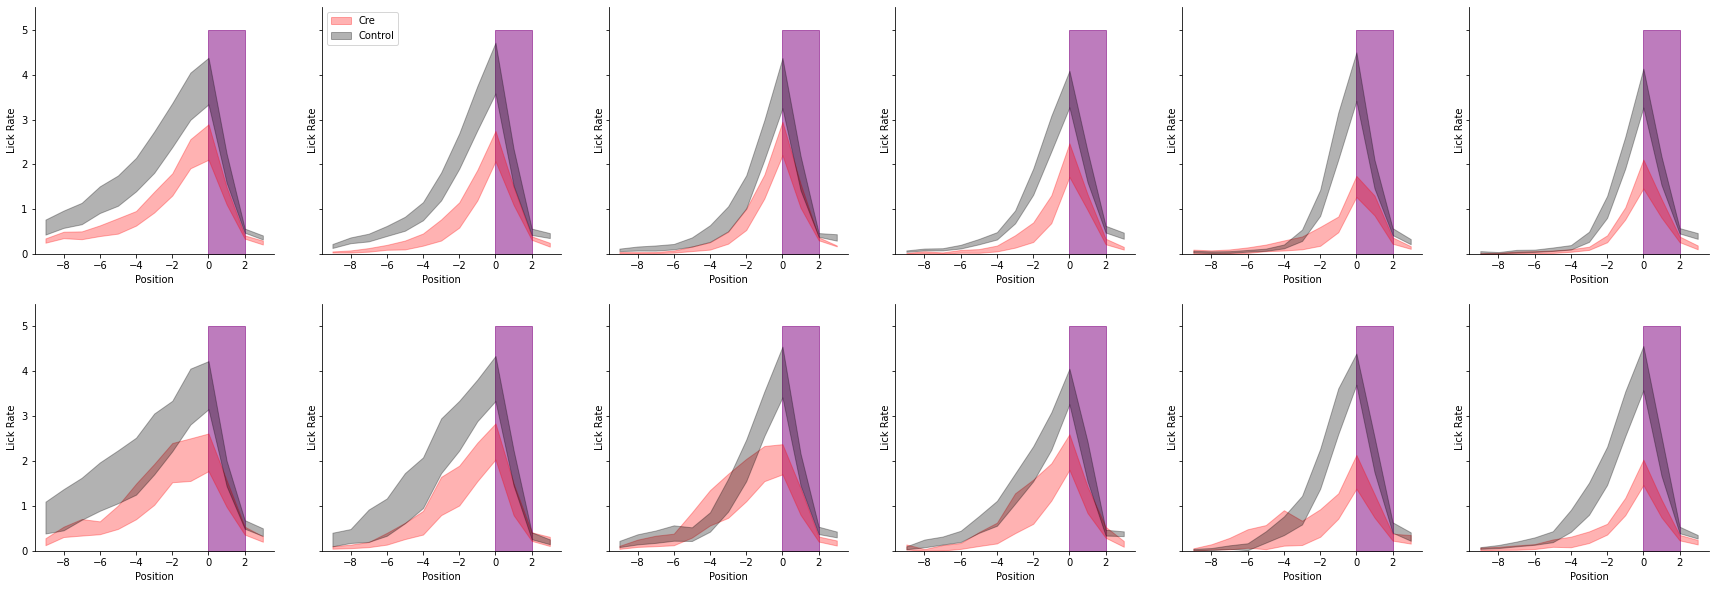

In [13]:
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)


df = pd.DataFrame({'mouse':[],
                        'ko':[],
                        'day':[],
                        'day_norm': [],
                        'dz': [],
                        'ko_x_day': [],
                        'nov':[],
                        'ko_x_nov': [],
                        'lr': [],
                        'lickrate':[], 
                        'intercept': [],
                        })

key = 'nonconsum_licks'
if key in ('licks', 'nonconsum_licks'):
    alpha = dt
elif key in ('speed'):
    alpha = dt*10
else:
    alpha = 1.
ko_lr, ctrl_lr = {}, {}
for day in range(6):
    ko_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                df = df.append({'mouse': mouse, 
                                 'ko': 1, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 1,
                                 'ko_x_nov': 1,
                                 'lr':ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ko_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                df = df.append({'mouse': mouse, 
                                 'ko': 1, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
#                 ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                
                    
                
       
                      

    ctrl_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-9,4)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
                df = df.append({'mouse': mouse, 
                                 'ko': 0, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 1,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ctrl_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
                
                df = df.append({'mouse': mouse, 
                                 'ko': 0, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
        
    

for day in range(6):
    for ax_ind, lr in enumerate(['fam', 'nov']):
        arr = np.array(ko_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3, label='Cre')

        arr = np.array(ctrl_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3, label='Control')
    #     ax[ax_ind].plot(x, np.array(ko_mu[lr]).T,color='red', alpha = .3)


    
        ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)
        ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)

        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_ylabel('Lick Rate')
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].set_ylim([0,5.5])
ax[0,1].legend(loc = 'upper left')

fig.savefig(os.path.join(fig_dir, 'famnov_lickrate_alldays.pdf'))

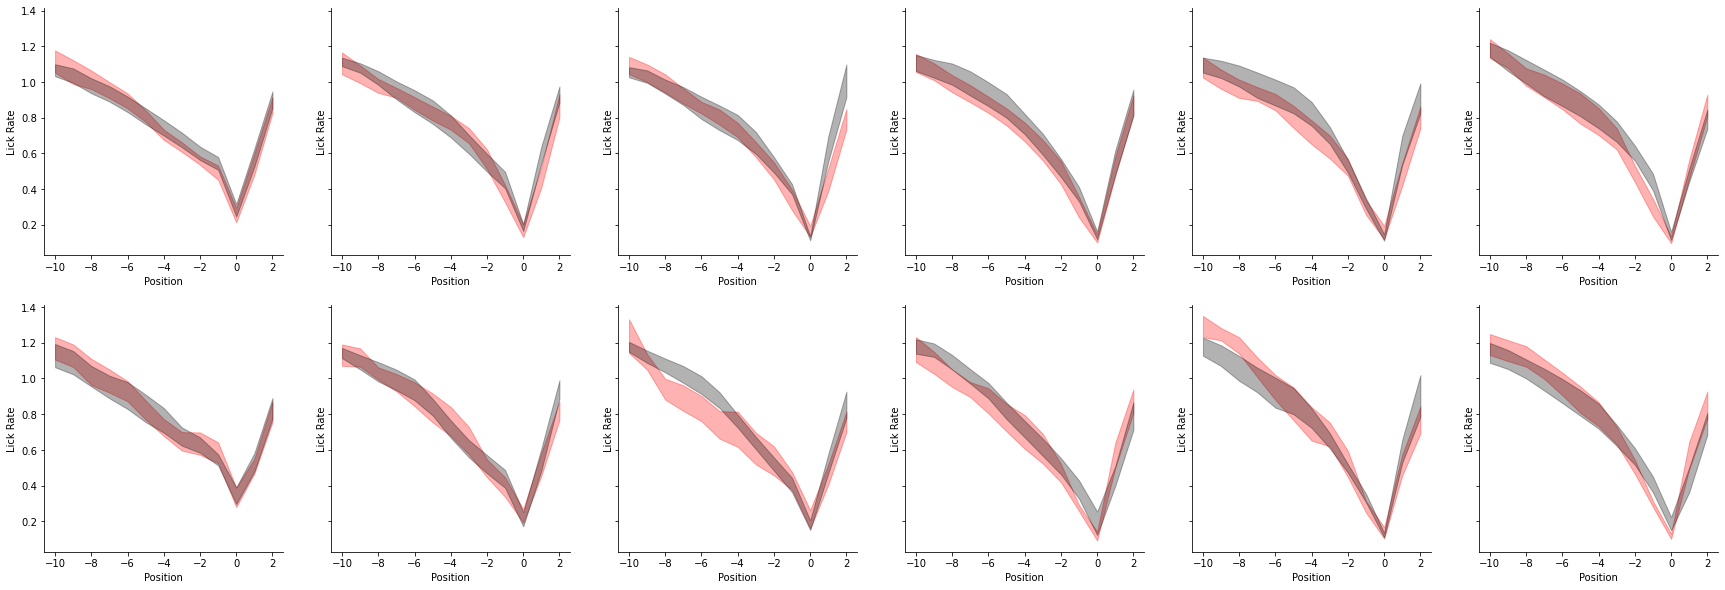

In [30]:
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)


df = pd.DataFrame({'mouse':[],
                        'ko':[],
                        'day':[],
                        'day_norm': [],
                        'dz': [],
                        'ko_x_day': [],
                        'nov':[],
                        'ko_x_nov': [],
                        'lr': [],
                        'lickrate':[], 
                        'intercept': [],
                        })

key = 'speed'
if key in ('licks', 'nonconsum_licks'):
    alpha = dt
elif key in ('speed'):
    alpha = dt*10
else:
    alpha = 1.
ko_lr, ctrl_lr = {}, {}
for day in range(6):
    ko_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            grand_mean = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:].ravel())
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)/grand_mean

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front])
                df = df.append({'mouse': mouse, 
                                 'ko': 1, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 1,
                                 'ko_x_nov': 1,
                                 'lr':ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ko_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front])
                df = df.append({'mouse': mouse, 
                                 'ko': 1, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': (day+1)/6.,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
#                 ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                
                    
                
       
                      

    ctrl_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-10,3)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','licks_sum','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
#             lick_mean = np.nanmean(sess.trial_matrices['licks_sum'][trial_mask,:].ravel())

#             mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)
            grand_mean = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:].ravel())
            mu = alpha*np.nanmean(sess.trial_matrices[key][trial_mask,:], axis=0)/grand_mean

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front])
                df = df.append({'mouse': mouse, 
                                 'ko': 0, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 1,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _nov,
                                 'intercept': 1,
                                }, ignore_index=True)
            else:
                ctrl_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front])
                
                df = df.append({'mouse': mouse, 
                                 'ko': 0, 
                                 'day': day,
                                 'day_norm': (day+1)/6.,
                                 'ko_x_day': 0,
                                 'nov': 0,
                                 'ko_x_nov': 0,
                                 'lr': ax_ind,
                                 'lickrate': _fam,
                                 'intercept': 1,
                                }, ignore_index=True)
        
    

for day in range(6):
    for ax_ind, lr in enumerate(['fam', 'nov']):
        arr = np.array(ko_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

        arr = np.array(ctrl_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)
    #     ax[ax_ind].plot(x, np.array(ko_mu[lr]).T,color='red', alpha = .3)


    
#         ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)
#         ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)

        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_ylabel('Lick Rate')
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)

# fig.savefig(os.path.join(fig_dir, 'famnov_lickrate_alldays.pdf'))

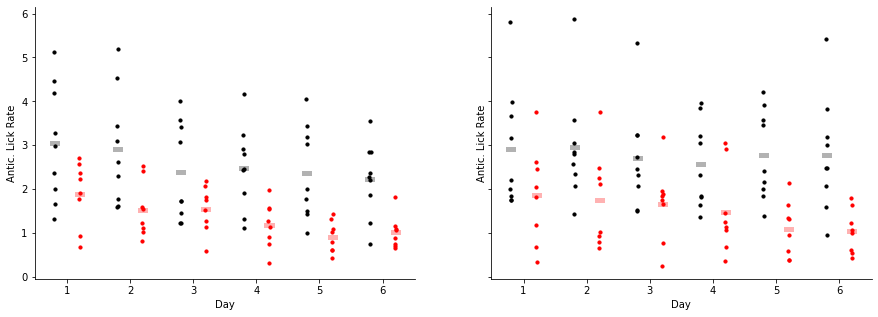

In [10]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==0)
    lr = df['lickrate'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['ko']==0) & (df['day']==day) & (df['nov']==1)
    lr = df['lickrate'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['ko']==1) & (df['day']==day) & (df['nov']==0)
    lr = df['lickrate'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['ko']==1) & (df['day']==day)& (df['nov']==1)
    lr = df['lickrate'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Antic. Lick Rate')
    ax[a].set_xlabel('Day')

fig.savefig(os.path.join(fig_dir, 'famnov_average_lickrate_summary.pdf'))

In [17]:

aov = mixed_anova(data=df[df['nov']==0], dv='lickrate', between='ko', within='day', subject='mouse')
print(aov)
print(aov['p-unc'].iloc[1])

posthoc = pairwise_ttests(data=df[df['nov']==0], dv='lickrate', between='ko', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0           ko  37.903867    1   15  37.903867  10.663782  0.005215  0.415519   
1          day   9.413276    5   75   1.882655   7.556441  0.000009  0.335001   
2  Interaction   0.997572    5   75   0.199514   0.800794  0.552612  0.050681   

        eps  
0       NaN  
1  0.688216  
2       NaN  
8.614145765397674e-06
    Contrast  day    A    B Paired  Parametric         T        dof  \
0        day    -  0.0  1.0   True        True  1.398939  16.000000   
1        day    -  0.0  2.0   True        True  2.754402  16.000000   
2        day    -  0.0  3.0   True        True  3.180116  16.000000   
3        day    -  0.0  4.0   True        True  4.929344  16.000000   
4        day    -  0.0  5.0   True        True  4.374278  16.000000   
5        day    -  1.0  2.0   True        True  1.984348  16.000000   
6        day    -  1.0  3.0   True        True  3.010909  16.000000   
7        day    -  1.0  4.0  

In [16]:
aov = mixed_anova(data=df[df['nov']==1], dv='lickrate', between='ko', within='day', subject='mouse')
print(aov)

        Source         SS  DF1  DF2         MS         F     p-unc       np2  \
0           ko  42.832149    1   15  42.832149  8.402531  0.011023  0.359044   
1          day   3.424709    5   75   0.684942  2.011024  0.086710  0.118219   
2  Interaction   2.254700    5   75   0.450940  1.323982  0.263227  0.081107   

       eps  
0      NaN  
1  0.70181  
2      NaN  


In [18]:
df_ =df[df['day']<5]
lmm_res = MixedLM(df_['lickrate'], df_[['ko', 
                                       'day_norm', 
                                       'nov', 
                                       'lr', 
                                       'ko_x_day', 
                                       'ko_x_nov', 
                                       'intercept']], df_['mouse'], exog_re = df_['day_norm'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lickrate 
No. Observations: 170     Method:             REML     
No. Groups:       17      Scale:              0.5077   
Min. group size:  10      Log-Likelihood:     -203.9642
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
ko           -0.904    0.280 -3.232 0.001 -1.453 -0.356
day_norm     -0.719    0.512 -1.406 0.160 -1.722  0.284
nov           0.083    0.151  0.549 0.583 -0.213  0.378
lr            0.542    0.111  4.865 0.000  0.323  0.760
ko_x_day     -0.708    0.746 -0.949 0.342 -2.170  0.754
ko_x_nov      0.146    0.223  0.656 0.512 -0.290  0.582
intercept     2.758    0.198 13.948 0.000  2.371  3.146
day_norm Var  1.442    0.865                           



In [4]:
sess = u.load_vr_day(ko_mice[7], 5)

{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1})
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 7}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10, 'novel_arm': -1, 'ravel_ind': 8})


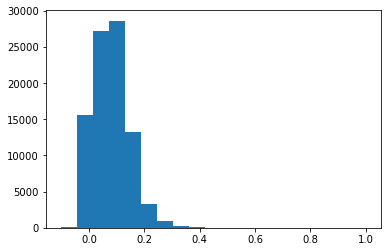

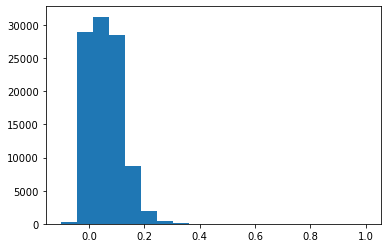

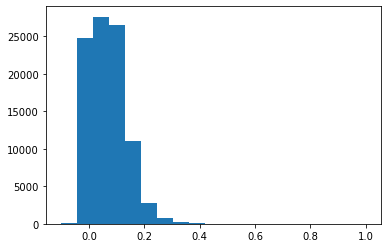

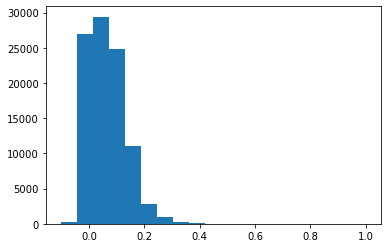

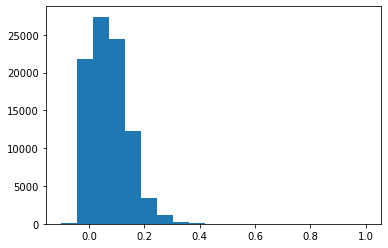

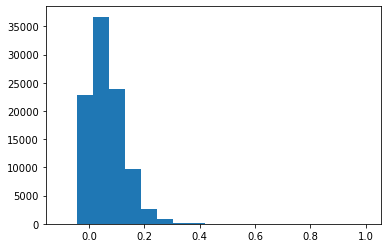

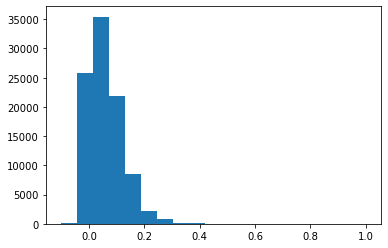

In [13]:
for i in range(7):
    sess = u.load_vr_day(ko_mice[0],i)
    fig,ax = plt.subplots()
    ax.hist(sess.timeseries['speed'].ravel(), bins = np.linspace(-.1,1, num=20))

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invali

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: inval

({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1})
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invali

{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': -1, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.0, 0.25)

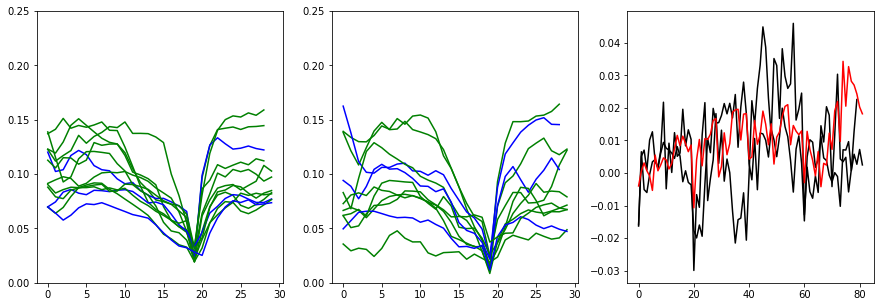

In [14]:
fig,ax = plt.subplots(1,3, figsize=[15,5])

for mouse in ctrl_mice:
    sess = u.load_vr_day(mouse,0)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[0].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )

    
for mouse in ko_mice:
    sess = u.load_vr_day(mouse,0)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[1].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
    
ax[0].set_ylim([0,.25])
ax[1].set_ylim([0,.25])
    

{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


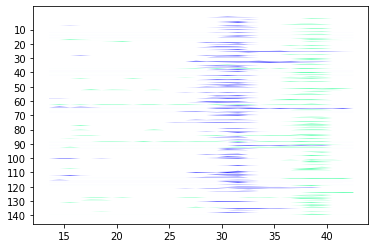

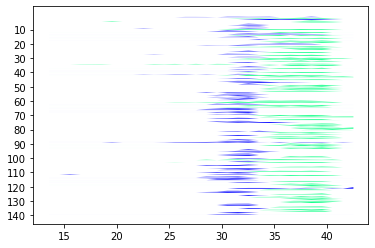

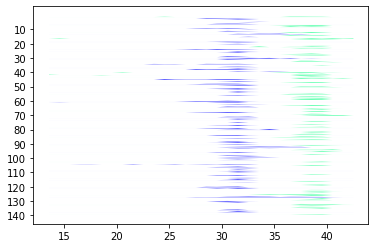

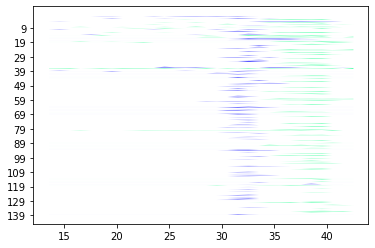

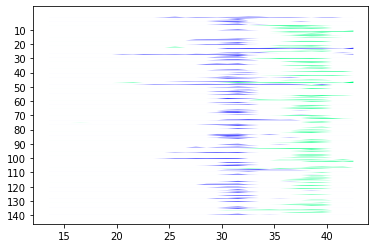

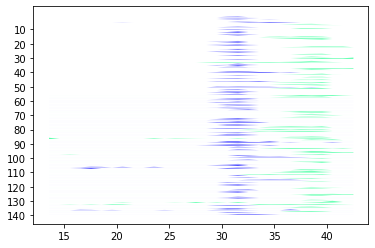

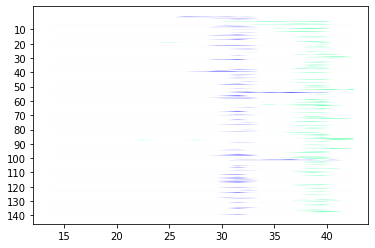

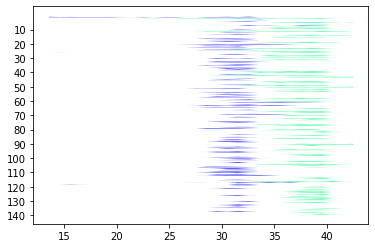

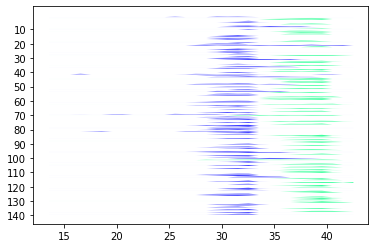

In [18]:
for mouse in ctrl_mice:
    sess = u.load_vr_day(mouse,5)
    
#     fig,ax = plt.subplots()
    fig, ax = tpu.utilities.smooth_raster(sess.trial_matrices['bin_centers'],sess.trial_matrices['licks'],vals = sess.trial_info['LR'],cmap='winter')
    